# Transfer Learning with TensorFlow Part 1: Feature Extraction

In [2]:
# Are we using a GPU?
!nvidia-smi

Tue Jan  9 20:32:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Downloading and becoming one with data

In [3]:
!git clone https://github.com/msyturk/image-classification-by-deep-learning.git

fatal: destination path 'image-classification-by-deep-learning' already exists and is not an empty directory.


In [4]:
import shutil
import os

# Main branch of the repo
project_folder = '/content/image-classification-by-deep-learning'

# Folder lists we are going to remove
folders_to_remove = ['.git', '.ipynb_checkpoints']

# Delete the folders
for folder in folders_to_remove:
    folder_path = os.path.join(project_folder, folder)
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)

In [5]:
# How many images in each folder?
import os

#Walk through the data directory and list number of files
for dirpath, dirnames, filenames in os.walk("/content/image-classification-by-deep-learning"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 6 directories and 1 images in '/content/image-classification-by-deep-learning'
There are 0 directories and 20 images in '/content/image-classification-by-deep-learning/Galaval'
There are 0 directories and 20 images in '/content/image-classification-by-deep-learning/Buchkeygala'
There are 0 directories and 20 images in '/content/image-classification-by-deep-learning/Superchief'
There are 0 directories and 20 images in '/content/image-classification-by-deep-learning/Golden'
There are 0 directories and 20 images in '/content/image-classification-by-deep-learning/Joremin'
There are 0 directories and 20 images in '/content/image-classification-by-deep-learning/Arjantin'


# Transfer Learning w/ pre-trained popular architectures

## Creating data loaders(preparing the data)
We'll use the ImageDataGenerator class to load in our images in batches.

In [6]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "/content/image-classification-by-deep-learning/"
test_dir = "/content/image-classification-by-deep-learning/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data = train_datagen.flow_from_directory(
             train_dir,
             target_size=IMAGE_SHAPE,
             batch_size=BATCH_SIZE,
             class_mode='categorical')

print("Testing images:")
test_data = test_datagen.flow_from_directory(
             test_dir,
             target_size=IMAGE_SHAPE,
             batch_size=BATCH_SIZE,
             class_mode='categorical')

Training images:
Found 120 images belonging to 6 classes.
Testing images:
Found 120 images belonging to 6 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfit) with the EarlyStopping callback

In [5]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import tensorflow as tf
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

In the past, we've used TensorFlow to create our own models layer by layer from scratch.

Now, we're going to do similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pre-trained models on https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0

In [6]:
# Let's compare the following two models
resnet_url = "https://www.kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/101-classification/versions/2"
efficientnet_url = "https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b0-classification/versions/1"
efficientnet_url_v2 = "https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet1k-b0-classification/versions/2"

In [7]:
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
# Make a create_model function to create a model from a URL
def create_model(model_url, num_classes=6):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL
    num_classes (int): Number of output neurons in the output layer, should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,)) # freeze the already learned patterns
  # Create our owm model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model


### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [9]:
# Create a Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=6)

In [16]:
# Compile our Resnet model
resnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [17]:
# Let's fit our ResNet model to the data
resnet_history = resnet_model.fit(train_data,
                                  epochs=20,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20240109-184453
Epoch 1/20
4/4 [==============================] - 19s 2s/step - loss: 1.9190 - accuracy: 0.4583 - val_loss: 1.3693 - val_accuracy: 0.4583
Epoch 2/20
4/4 [==============================] - 3s 901ms/step - loss: 1.2858 - accuracy: 0.5167 - val_loss: 1.0540 - val_accuracy: 0.5917
Epoch 3/20
4/4 [==============================] - 3s 781ms/step - loss: 0.9532 - accuracy: 0.6417 - val_loss: 0.7704 - val_accuracy: 0.7167
Epoch 4/20
4/4 [==============================] - 3s 837ms/step - loss: 0.7408 - accuracy: 0.7333 - val_loss: 0.6532 - val_accuracy: 0.7833
Epoch 5/20
4/4 [==============================] - 4s 1s/step - loss: 0.6064 - accuracy: 0.8083 - val_loss: 0.5199 - val_accuracy: 0.8333
Epoch 6/20
4/4 [==============================] - 3s 990ms/step - loss: 0.4974 - accuracy: 0.8333 - val_loss: 0.4564 - val_accuracy: 0.8417
Epoch 7/20
4/4 [==============================] - 3s 820ms/step - loss: 0.4474 - accuracy:

In [5]:
# Let's create a function to plot our loss curves...
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns seperate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epoch = range(len(history.history["loss"]))

  # Plot the curves
  plt.figure(figsize=(6,4))
  plt.plot(epoch, loss, label="training_loss")
  plt.plot(epoch, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure(figsize=(6,4))
  plt.plot(epoch, accuracy, label="training_accuracy")
  plt.plot(epoch, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

In [6]:
# Plot the validation and training curves
def plot_loss_curves_v2(history_1, history_2, history_3):
  """
  Returns seperate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss_1 = history_1.history["loss"]
  loss_2 = history_2.history["loss"]
  loss_3 = history_3.history["loss"]

  val_loss_1 = history_1.history["val_loss"]
  val_loss_2 = history_2.history["val_loss"]
  val_loss_3 = history_3.history["val_loss"]

  accuracy_1 = history_1.history["accuracy"]
  accuracy_2 = history_2.history["accuracy"]
  accuracy_3 = history_3.history["accuracy"]

  val_accuracy_1 = history_1.history["val_accuracy"]
  val_accuracy_2 = history_2.history["val_accuracy"]
  val_accuracy_3 = history_3.history["val_accuracy"]

  epoch = range(len(history_1.history["loss"]))

  # Plot the curves
  plt.figure(figsize=(6,4))
  plt.plot(epoch, loss_1, label="Training_loss_1")
  plt.plot(epoch, loss_2, label="Training_loss_2")
  plt.plot(epoch, loss_3, label="Training_loss_3")
  plt.title("Training Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure(figsize=(6,4))
  plt.plot(epoch, val_loss_1, label="val_loss_1")
  plt.plot(epoch, val_loss_2, label="val_loss_2")
  plt.plot(epoch, val_loss_3, label="val_loss_3")
  plt.title("Validation Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure(figsize=(6,4))
  plt.plot(epoch, accuracy_1, label="training_accuracy_1")
  plt.plot(epoch, accuracy_2, label="training_accuracy_2")
  plt.plot(epoch, accuracy_3, label="training_accuracy_3")
  plt.title("Training Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

  plt.figure(figsize=(6,4))
  plt.plot(epoch, val_accuracy_1, label="val_accuracy_1")
  plt.plot(epoch, val_accuracy_2, label="val_accuracy_2")
  plt.plot(epoch, val_accuracy_3, label="val_accuracy_3")
  plt.title("Validation Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

### Creating and testing EfficientNet TensorFlow Hub Feature Extraction model

In [20]:
# Create an EfficientNet model
efficient_model_v1 = create_model(model_url=efficientnet_url,
                               num_classes=6)

In [21]:
efficient_model_v1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

In [22]:
efficientnet_v1_history=efficient_model_v1.fit(train_data,
                    epochs=20,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data),
                    callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                           experiment_name="efficientnet_v1")])

Saving TensorBoard log files to: tensorflow_hub/efficientnet_v1/20240109-184634
Epoch 1/20
4/4 [==============================] - 16s 1s/step - loss: 1.7872 - accuracy: 0.2250 - val_loss: 1.7852 - val_accuracy: 0.3333
Epoch 2/20
4/4 [==============================] - 3s 721ms/step - loss: 1.7844 - accuracy: 0.3667 - val_loss: 1.7826 - val_accuracy: 0.3667
Epoch 3/20
4/4 [==============================] - 3s 764ms/step - loss: 1.7816 - accuracy: 0.3667 - val_loss: 1.7800 - val_accuracy: 0.3833
Epoch 4/20
4/4 [==============================] - 4s 1s/step - loss: 1.7791 - accuracy: 0.3833 - val_loss: 1.7774 - val_accuracy: 0.3833
Epoch 5/20
4/4 [==============================] - 4s 1s/step - loss: 1.7763 - accuracy: 0.3917 - val_loss: 1.7748 - val_accuracy: 0.3917
Epoch 6/20
4/4 [==============================] - 4s 1s/step - loss: 1.7738 - accuracy: 0.3917 - val_loss: 1.7721 - val_accuracy: 0.3917
Epoch 7/20
4/4 [==============================] - 3s 773ms/step - loss: 1.7711 - accuracy: 

In [23]:
efficient_model_v2 = create_model(model_url=efficientnet_url_v2,
                                  num_classes=6)

In [24]:
efficient_model_v2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

In [25]:
efficientnet_history_v2=efficient_model_v2.fit(train_data,
                                               epochs=20,
                                               steps_per_epoch=len(train_data),
                                               validation_data=test_data,
                                               validation_steps=len(test_data),
                                               callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                      experiment_name="efficientnet_v2")])

Saving TensorBoard log files to: tensorflow_hub/efficientnet_v2/20240109-184814
Epoch 1/20
4/4 [==============================] - 14s 2s/step - loss: 2.2751 - accuracy: 0.1667 - val_loss: 1.6347 - val_accuracy: 0.3250
Epoch 2/20
4/4 [==============================] - 3s 790ms/step - loss: 1.3986 - accuracy: 0.4583 - val_loss: 1.1831 - val_accuracy: 0.4917
Epoch 3/20
4/4 [==============================] - 3s 732ms/step - loss: 1.0574 - accuracy: 0.6000 - val_loss: 0.7873 - val_accuracy: 0.7583
Epoch 4/20
4/4 [==============================] - 4s 1s/step - loss: 0.7028 - accuracy: 0.8083 - val_loss: 0.6130 - val_accuracy: 0.8167
Epoch 5/20
4/4 [==============================] - 3s 858ms/step - loss: 0.5856 - accuracy: 0.8333 - val_loss: 0.5197 - val_accuracy: 0.8750
Epoch 6/20
4/4 [==============================] - 3s 817ms/step - loss: 0.4880 - accuracy: 0.8750 - val_loss: 0.4466 - val_accuracy: 0.8917
Epoch 7/20
4/4 [==============================] - 3s 897ms/step - loss: 0.4287 - accu

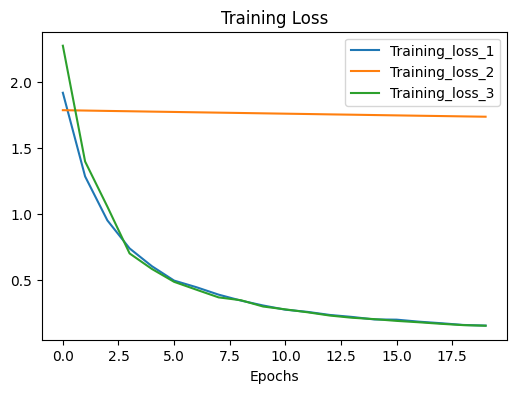

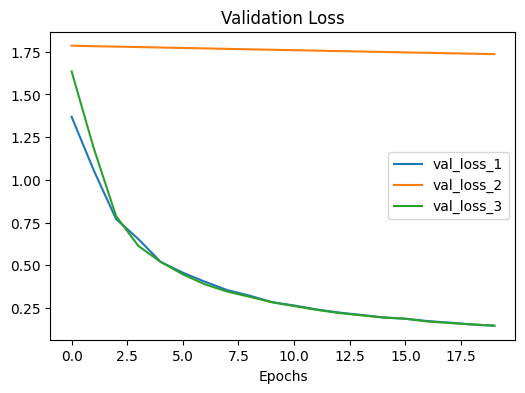

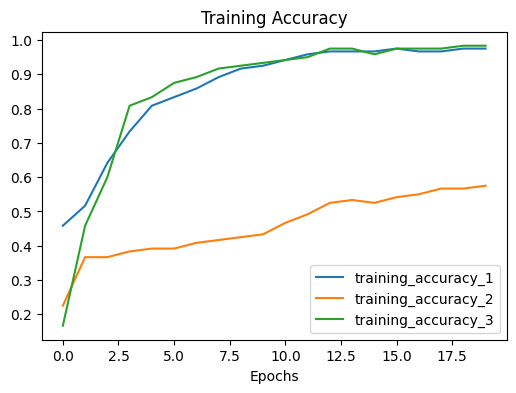

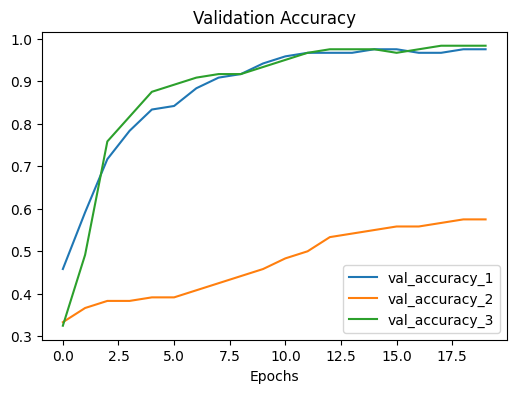

In [26]:
plot_loss_curves_v2(resnet_history, efficientnet_v1_history, efficientnet_history_v2)

### Creating and testing AlexNet Feature Extraction model

# Other ML Algorithms

In [7]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [8]:
# Veri Setinden Özellikleri ve Etiketleri Çıkar
num_samples = len(train_data.filenames)
num_classes = train_data.num_classes

In [9]:
features = []
labels = []

for _ in range(num_samples):
    batch = train_data.next()
    features.extend(batch[0])
    labels.extend(batch[1])

features = np.array(features)
labels = np.argmax(np.array(labels), axis=1)

In [10]:
# Create classifiers
svm_classifier = SVC(kernel='linear', C=1)
knn_classifier = KNeighborsClassifier(n_neighbors=3)
dt_classifier = DecisionTreeClassifier()

In [11]:
# 5-fold cross-validation architectures
classifiers = [svm_classifier, knn_classifier, dt_classifier]

In [13]:
for classifier in classifiers:
    scores = cross_val_score(classifier, features.reshape(features.shape[0], -1), labels, cv=5)
    print(f"{classifier.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores)}")

KeyboardInterrupt: 

All three models above provides the same result of `1.0` accuracy